In [1]:
#Aerial Lidar Vectorization: Implement Setup

#Base libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#3D libraries
import open3d as o3d
import laspy
print(laspy.__version__)

#Geospatial libraries
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh

from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import shapes
from shapely.geometry import Polygon

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
2.5.3


In [2]:
#Data Profiling

#neighborhood
las = laspy.read('DATA/Vecindario2.las')

#single building


#explore the classification field
print(np.unique(las.classification))
print([dimension.name for dimension in las.point_format.dimensions])

#explore CRS info
csr = las.vlrs[2].string
print(las.vlrs[2].string)

[1 2 3 5 6 7]
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']
PROJCS["NAD_1983_UTM_Zone_10N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0],AUTHORITY["EPSG",26910]]


In [3]:
#Building points initialization
#create a mask to filter points

pts_mask = las.classification == 6

#apply the mask and get the coordinates of the filtered dataset
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

#transform to open3D.o3d.geometry,PointCloud and visualize
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(xyz_t.transpose())

#translate the point cloud, and keep the translation to reapply at the end
pcd_center = pcd_o3d.get_center()
pcd_o3d.translate(-pcd_center)

#visualize the results
o3d.visualization.draw_geometries([pcd_o3d])

In [4]:
#Isolating ground points
pts_mask = las.classification == 2
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))


ground_pts = o3d.geometry.PointCloud()
ground_pts.points = o3d.utility.Vector3dVector(xyz_t.transpose())
ground_pts.translate(-pcd_center)

o3d.visualization.draw_geometries([ground_pts])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: La operación de transformación solicitada no es compatible. 


In [5]:
#Identifying the average distance between building points
nn_distance = np.mean(pcd_o3d.compute_nearest_neighbor_distance())
print("average point distance (m): ", nn_distance)

average point distance (m):  0.0507989602045808


In [6]:
#Unsupervised Segmentation (Clustering) with DBSCAN

#Definition of the parameters epsilon, and the minimum number of points to be considered a relevant cluster
epsilon = 2
min_cluster_points = 100

labels = np.array(pcd_o3d.cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

#We use a discrete color palette to randomize the visualization
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:, :3])

#Point Cloud Visualization
o3d.visualization.draw_geometries([pcd_o3d])

point cloud has 36 clusters
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: La operación de transformación solicitada no es compatible. 


In [7]:
#Selecting a segment to be considered
sel = 1
segment = pcd_o3d.select_by_index(np.where(labels==sel)[0])
o3d.visualization.draw_geometries([segment])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Controlador no válido. 


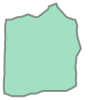

In [8]:
#Extracting the outline (building footprint) of the selection

#We extract only the X and Y coordinates of our point cloud (Note: it is local)
points_2D = np.asarray(segment.points)[:,0:2]

#We compute the shape (alpha shape) and return the result with shapely
building_vector = ash.alphashape(points_2D, alpha=0.5)
building_vector

In [9]:
#Store in a Geodataframe the 2D polygon
building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs='EPSG:26910')
building_gdf.head(1)

,geometry
0,"POLYGON ((-73.635 -29.245, -73.666 -29.245, -7..."


In [10]:
#Computing semantics and attributes

#The height of the building as a relative measure

altitude = np.asarray(segment.points)[:,2]+pcd_center[2]
height_test = np.max(altitude)- np.min(altitude)
print('Is this correct: ',height_test)

#We first have to define the ground level in our local area
query_point = segment.get_center()
query_point[2] = segment.get_min_bound()[2]
pcd_tree = o3d.geometry.KDTreeFlann(ground_pts)
[k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 200)

#From the nn search, we extract the points that belong to the ground and paint them grey
sample = ground_pts.select_by_index(idx, invert=False)
sample.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_geometries([sample, ground_pts])

#Extract the mean value of the ground in this specific place
ground_zero = sample.get_center()[2]

#Compute the true height of the building, roof included:
height = segment.get_max_bound()[2] - ground_zero
print('True Height: ', height)

#Check the difference: 
print('Height Difference: ', height - height_test)

Is this correct:  8.741
True Height:  9.197769999999997
Height Difference:  0.456769999999997


In [11]:
#Computing parameters
building_gdf[['id']] = sel
building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
building_gdf[['area']] = building_vector.area
building_gdf[['perimeter']] = building_vector.length
building_gdf[['local_cx','local_cy','local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
building_gdf[['transl_x','transl_y','transl_z']] = pcd_center
building_gdf[['pts_number']] = len(segment.points)

#print
building_gdf.head(1)

,geometry,id,height,area,perimeter,local_cx,local_cy,local_cz,transl_x,transl_y,transl_z,pts_number
0,"POLYGON ((-73.635 -29.245, -73.666 -29.245, -7...",1,9.19777,201.64225,56.825554,-66.839315,-21.659537,-6.330604,489655.259783,5.451517e+06,53.994834,13305


In [12]:
#2D to 3D Library: From a shapely Vector dataset to an Open3D LineSet
#The base layer
#Generate the vertice list
vertices = list(building_vector.exterior.coords)

#Construct the Open3D Object
polygon_2d = o3d.geometry.LineSet()
polygon_2d.points = o3d.utility.Vector3dVector([point + (0,) for point in vertices])
polygon_2d.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])

#Visualization
o3d.visualization.draw_geometries([polygon_2d])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: La operación de transformación solicitada no es compatible. 


In [13]:
#The top layer
#Generate the same element for the Extruded
extrusion = o3d.geometry.LineSet()
extrusion.points = o3d.utility.Vector3dVector([point + (height,) for point in vertices])
extrusion.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])
o3d.visualization.draw_geometries([polygon_2d, extrusion])

#Plot the vertices
temp = polygon_2d + extrusion
temp.points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = temp.points
o3d.visualization.draw_geometries([temp_o3d])

In [14]:
#Generating the base vertices for the 3D Mesh with Numpy
a = np.array(building_vector.exterior.coords)
b = np.ones([a.shape[0],1])*sample.get_center()[2]
c = np.ones([a.shape[0],1])*(sample.get_center()[2] + height)

#Define the ground footprint and the height arrays of points
ground_pc = np.hstack((a, b))
up_pc = np.hstack((a, c))

#Generate an Open3D "point cloud" made of the major points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = o3d.utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))
o3d.visualization.draw_geometries([temp_o3d])

In [15]:
#Computing the alpha Shape of the 3D base points
alpha = 20
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.5,0.4,0])
o3d.visualization.draw_geometries([temp_o3d, mesh, segment], mesh_show_back_face=True)

alpha=20.000
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra

In [16]:
#Post-Processing Operations & Export
#Repositioning the mesh from local to the world coordinates
mesh.translate(pcd_center)

#Export the Mesh
o3d.io.write_triangle_mesh('RESULTS/house_sample.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False, write_vertex_colors=False, write_triangle_uvs=False)

#Export the shapefile
building_gdf.to_file("RESULTS/single_building.shp")

In [17]:
#12. Automation and Scaling 3D City Modelling

# Optional utility
import random
def random_color_generator():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return [r/255, g/255, b/255]

#Initializing the GeodataFrame
buildings_gdf = gpd.GeoDataFrame(columns=['id', 'geometry', 'height', 'area', 'perimeter', 'local_cx', 'local_cy', 'local_cz', 'transl_x', 'transl_y', 'transl_z'], geometry='geometry', crs='EPSG:26910')

# Reducing the output wave of Open3D
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

#Creating the loop
for sel in range(max_label+1):
    #1. Select the Segment
    segment = pcd_o3d.select_by_index(np.where(labels==sel)[0])
    # o3d.visualization.draw_geometries([segment])

    #2. Compute the building footprint
    # altitude = np.asarray(segment.points)[:,2]+pcd_center[2]
    points_2D = np.asarray(segment.points)[:,0:2]
    building_vector = ash.alphashape(points_2D, alpha=0.5)
    
    #3. Compute the height of the segment (house candidate).
    query_point = segment.get_center()
    query_point[2] = segment.get_min_bound()[2]
    pcd_tree = o3d.geometry.KDTreeFlann(ground_pts)
    [k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 50)
    sample = ground_pts.select_by_index(idx, invert=False)
    ground_zero = sample.get_center()[2]
    
    #4. Create the geopandas with attributes entry
    building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs='EPSG:26910')
    building_gdf[['id']] = sel
    building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
    building_gdf[['area']] = building_vector.area
    building_gdf[['perimeter']] = building_vector.length
    building_gdf[['local_cx','local_cy','local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
    building_gdf[['transl_x','transl_y','transl_z']] = pcd_center
    building_gdf[['pts_number']] = len(segment.points)
    
    #4. Add it to geometries entries
    buildings_gdf = pd.concat([buildings_gdf, building_gdf])

    #5. Compute the 3D Vertices Geometries
    a = np.array(building_vector.exterior.coords)
    b = np.ones([a.shape[0],1])*sample.get_center()[2]
    c = np.ones([a.shape[0],1])*(sample.get_center()[2] + height)
    ground_pc = np.hstack((a, b))
    up_pc = np.hstack((a, c))
    temp_o3d = o3d.geometry.PointCloud()
    temp_o3d.points = o3d.utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))
    
    #6. Compute the 3D Geometry of a house 
    alpha = 20
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
    mesh.translate(pcd_center)
    mesh.paint_uniform_color(random_color_generator())    #5. Compute the 3D Vertices Geometries

    
    o3d.io.write_triangle_mesh('RESULTS/house_'+str(sel)+'.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False)

C:\Users\cahh1\AppData\Local\Temp\ipykernel_10036\3397541805.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  buildings_gdf = pd.concat([buildings_gdf, building_gdf])


In [18]:
buildings_gdf

,id,geometry,height,area,perimeter,local_cx,local_cy,local_cz,transl_x,transl_y,transl_z,pts_number
0,0,"POLYGON ((-76.603 -24.245, -76.572 -24.745, -7...",9.10238,212.90875,58.093835,-82.722341,-21.984546,-6.243214,489655.259783,5.451517e+06,53.994834,14877.0
0,1,"POLYGON ((-73.635 -29.245, -73.666 -29.245, -7...",9.18550,201.64225,56.825554,-66.839315,-21.659537,-6.318334,489655.259783,5.451517e+06,53.994834,13305.0
0,2,"POLYGON ((-67.978 -27.245, -67.666 -26.745, -6...",2.01594,6.43025,9.906943,-66.799087,-27.911751,-6.312774,489655.259783,5.451517e+06,53.994834,122.0
0,3,"POLYGON ((-51.260 -13.745, -51.166 -13.745, -5...",8.23926,151.86200,49.562612,-51.589533,-21.481142,-6.148094,489655.259783,5.451517e+06,53.994834,10198.0
0,4,"POLYGON ((-31.010 -13.745, -30.853 -13.745, -3...",7.09050,188.79875,55.029135,-35.772098,-21.913926,-6.179334,489655.259783,5.451517e+06,53.994834,11367.0
0,5,"POLYGON ((-14.697 -28.245, -14.666 -29.245, -1...",9.30620,185.18750,53.139262,-20.856928,-24.079900,-6.219034,489655.259783,5.451517e+06,53.994834,12743.0
0,6,"POLYGON ((-3.947 -16.245, -3.885 -16.245, -3.8...",9.61652,202.45000,56.432231,-5.706847,-24.023378,-6.107354,489655.259783,5.451517e+06,53.994834,14751.0
0,7,"POLYGON ((14.522 -31.745, 14.428 -31.745, 14.3...",9.28590,193.45275,55.175265,10.006410,-23.895658,-5.827734,489655.259783,5.451517e+06,53.994834,14531.0
0,8,"POLYGON ((-6.728 -16.745, -6.603 -16.745, -6.4...",2.36382,2.31250,8.331680,-7.504986,-17.095310,-6.186654,489655.259783,5.451517e+06,53.994834,88.0
0,9,"POLYGON ((69.178 -34.245, 69.147 -34.245, 69.1...",9.49962,716.13075,121.561981,54.737661,-24.755871,-5.078454,489655.259783,5.451517e+06,53.994834,46684.0


In [19]:
#Exporting the geometry are in a local frame of reference
buildings_gdf.to_file("RESULTS/neighborhood_buildings.shp")